In [19]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [82]:
plt.rcParams['font.size'] = 18

In [25]:
from tabascal.jax.interferometry import rfi_vis
from tabascal.jax.coordinates import orbit

In [24]:
def readObs(file_path):
    obs = {}
    with h5py.File(file_path, 'r') as fp:
        for track in fp.keys():
            obs[track] = {}
            for key in fp[track].keys():
                obs[track][key] = fp[track][key][()]

    return obs

def linear_extrapolate(x, xp, fp, N_int_samples):

    N_ext = int(N_int_samples/2)

    xi = x[:N_ext]
    xf = x[-N_ext:]

    x_int = x[N_ext:-N_ext]
    y_int = np.interp(x_int, xp, fp)

    dyi = (y_int[1]-y_int[0])/(x_int[1]-x_int[0])
    dyf = (y_int[-1]-y_int[-2])/(x_int[-1]-x_int[-2])

    yi = y_int[0] + dyi*(xi - xp.min())
    yf = y_int[-1] + dyf*(xf - xp.max())

    return np.concatenate([np.array(yi), np.array(y_int), np.array(yf)])

In [6]:
obs = readObs('imaging_dict_7min.h5')

In [27]:
rfi_orbit = obs['track1']['rfi_orbit']

In [16]:
n_int = obs['track1']['n_int_samples']
n_time = obs['track1']['n_time']
n_bl = obs['track1']['vis_obs'].shape[1]

In [48]:
vis_obs = obs['track1']['vis_obs'][...,0]
vis_ast = obs['track1']['vis_ast'][...,0].reshape(n_time, n_int, n_bl).mean(axis=1)
vis_rfi = obs['track1']['vis_rfi'][...,0].reshape(n_time, n_int, n_bl).mean(axis=1)
noise = obs['track1']['noise'][...,0]

vis_cal = vis_ast + vis_rfi + noise

In [111]:
vis_obs = obs['track1']['vis_obs'][...,0]
vis_ast = obs['track1']['vis_ast'][...,0]#.reshape(n_time, n_int, n_bl).mean(axis=1)
vis_rfi = obs['track1']['vis_rfi'][...,0]#.reshape(n_time, n_int, n_bl).mean(axis=1)


(0.0, 2.0)

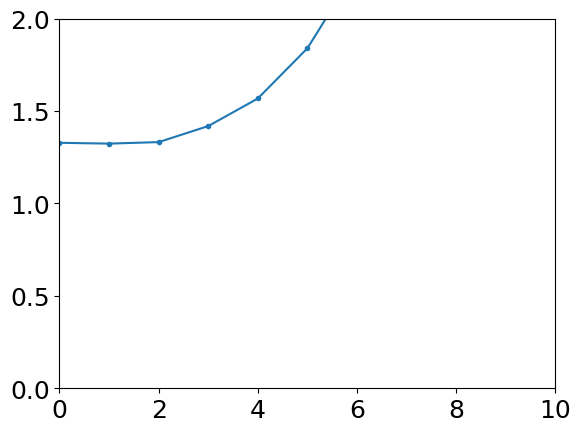

In [91]:
plt.plot(np.abs(vis_cal).mean(axis=1), '.-');
plt.xlim(0, 10)
plt.ylim(0, 2)

In [84]:
def correct_vis(mcmc, track, vis_obs_cal, rfi_orbit, n_wraps=10, n_bl_avg=10, N_sol=1):

    N_time = mcmc[track]['n_time']
    N_int_samples = mcmc[track]['n_int_samples']
    N_ant = mcmc[track]['n_ant']
    N_freq = mcmc[track]['n_freq']
    N_corr = 1
    a1 = mcmc[track]['antenna1']
    a2 = mcmc[track]['antenna2']
    N_bl = len(a1)
    times_fine = mcmc[track]['times_fine']
    vis_obs = np.abs(mcmc[track]['vis_obs']).mean(axis=(1,2))
    rfi_amp = linear_extrapolate(times_fine, mcmc[track]['times'], vis_obs, N_int_samples).reshape(N_time, N_int_samples)/vis_obs[:,None]

    # Calculate expected rfi vis phase
    rfi_xyz = orbit(times_fine, *rfi_orbit)
    distances = np.linalg.norm(mcmc[track]['ants_XYZ']-rfi_xyz[:,None,:], axis=2)
    c_distances = (distances-mcmc[track]['ants_UVW'][...,-1])[None,...]
    
    # rfi_vis_fine = rfi_vis(np.ones((N_time*N_int_samples,N_ant,1,1)),
    #                        c_distances, mcmc[track]['freqs'])[...,0]
    rfi_vis_fine = rfi_vis(rfi_amp.reshape(1,-1,1,1)*np.ones((1,N_time*N_int_samples,N_ant,1)),
                           c_distances, mcmc[track]['freqs'], a2, a1)[...,0]

    # Choose baselines where the phase wrap on full track is closest to unity
    rfi_phase_uw = np.unwrap(np.angle(rfi_vis_fine), discont=0, axis=0)
    rfi_n_wraps = np.abs((rfi_phase_uw[0]-rfi_phase_uw[-1]))/(2*np.pi)
    bl_idx = np.argsort(np.abs(rfi_n_wraps-n_wraps))
    # Estimate rfi amplitude by averaging over time on calibrated visibilities of chosen baselines
    rfi_amp_est = np.abs(vis_obs_cal[:,bl_idx[:n_bl_avg]] - \
                         vis_obs_cal[:,bl_idx[:n_bl_avg]].mean(axis=0, keepdims=True)).mean(axis=-1)
    # Average down unitary rfi visibilities
    rfi_vis_avg = rfi_vis_fine.reshape(N_time, N_int_samples, N_bl).mean(axis=1)
    # Calculate estimated rfi visibilities
    vis_rfi_est = rfi_amp_est[:,None]*rfi_vis_avg
    # Calculate calibrated astronomical visibilities
    vis_corr = (vis_obs_cal - vis_rfi_est)#.reshape(-1, N_freq, N_corr)

    return vis_corr, vis_rfi_est, rfi_amp, rfi_vis_fine, rfi_amp_est

In [114]:
def correct_vis(mcmc, track, vis_obs_cal, rfi_orbit, n_wraps=10, n_bl_avg=10, N_sol=1):

    N_time = mcmc[track]['n_time']
    N_int_samples = mcmc[track]['n_int_samples']
    N_ant = mcmc[track]['n_ant']
    N_freq = mcmc[track]['n_freq']
    N_corr = 1
    a1 = mcmc[track]['antenna1']
    a2 = mcmc[track]['antenna2']
    N_bl = len(a1)
    times_fine = mcmc[track]['times_fine']
    vis_obs = np.abs(mcmc[track]['vis_obs']).mean(axis=(1,2))
    # rfi_amp = linear_extrapolate(times_fine, mcmc[track]['times'], vis_obs, N_int_samples).reshape(N_time, N_int_samples)/vis_obs[:,None]

    # Calculate expected rfi vis phase
    rfi_xyz = orbit(times_fine, *rfi_orbit)
    distances = np.linalg.norm(mcmc[track]['ants_XYZ']-rfi_xyz[:,None,:], axis=2)
    c_distances = (distances-mcmc[track]['ants_UVW'][...,-1])[None,...]
    
    # rfi_vis_fine = rfi_vis(np.ones((N_time*N_int_samples,N_ant,1,1)),
    #                        c_distances, mcmc[track]['freqs'])[...,0]
    rfi_vis_fine = rfi_vis(np.ones((1,N_time*N_int_samples,N_ant,1)),
                           c_distances, mcmc[track]['freqs'], a2, a1)[...,0]

    # Choose baselines where the phase wrap on full track is closest to unity
    rfi_phase_uw = np.unwrap(np.angle(rfi_vis_fine), discont=0, axis=0)
    rfi_n_wraps = np.abs((rfi_phase_uw[0]-rfi_phase_uw[-1]))/(2*np.pi)
    bl_idx = np.argsort(np.abs(rfi_n_wraps-n_wraps))
    # Estimate rfi amplitude by averaging over time on calibrated visibilities of chosen baselines
    rfi_amp_est = np.abs(vis_obs_cal[:,bl_idx[:n_bl_avg]] - \
                         vis_obs_cal[:,bl_idx[:n_bl_avg]].mean(axis=0, keepdims=True))
    rfi_amp = linear_extrapolate(times_fine, mcmc[track]['times'], rfi_amp_est.mean(axis=-1), N_int_samples)
    # Calculate estimated rfi visibilities
    vis_rfi_fine = rfi_amp[:,None] * rfi_vis_fine
    # Avergae down the visibilities
    vis_rfi_est = vis_rfi_fine.reshape(N_time, N_int_samples, N_bl).mean(axis=1)
    # Calculate calibrated astronomical visibilities
    vis_corr = (vis_obs_cal - vis_rfi_est)#.reshape(-1, N_freq, N_corr)

    return vis_corr, vis_rfi_est, rfi_amp, rfi_vis_fine, rfi_amp_est

In [115]:
vis_corr, vis_rfi_est, rfi_amp, rfi_vis_fine, rfi_amp_est = correct_vis(obs, 'track1', vis_cal, rfi_orbit, n_wraps=20, n_bl_avg=200)

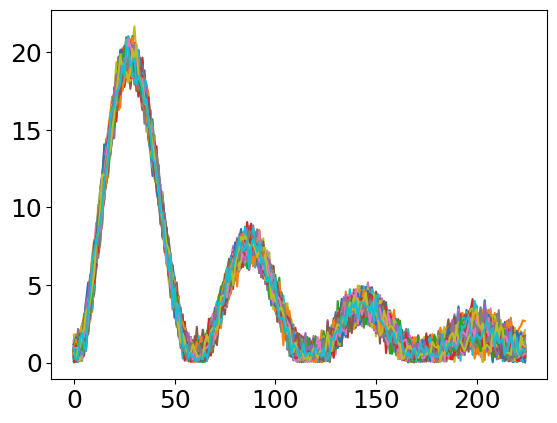

In [116]:
plt.plot(rfi_amp_est);

Text(0, 0.5, 'RFI Amp')

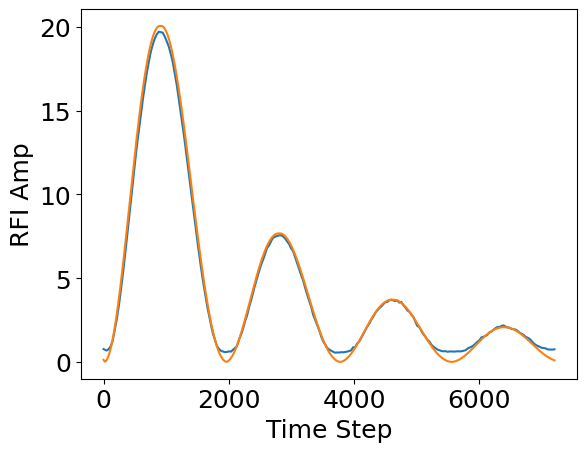

In [113]:
plt.plot(rfi_amp)
plt.plot(np.abs(vis_rfi).max(axis=1));
plt.xlabel('Time Step')
plt.ylabel('RFI Amp')
# plt.xlim(60, 120)
# plt.xlim(0, 32)

(0.0, 2.0)

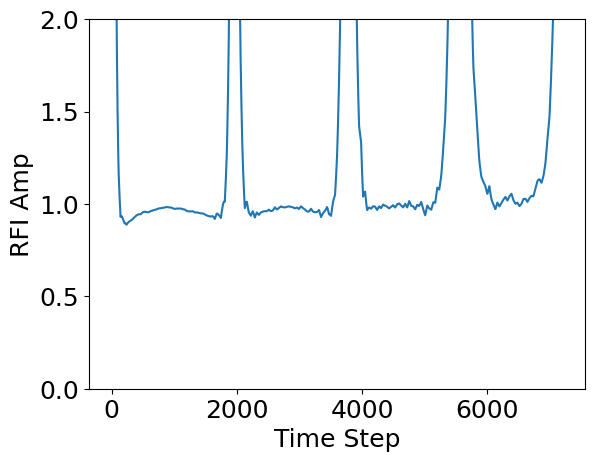

In [118]:
plt.plot(rfi_amp/np.abs(vis_rfi).max(axis=1))
# plt.plot();
plt.xlabel('Time Step')
plt.ylabel('RFI Amp')
plt.ylim(0, 2)
# plt.xlim(60, 120)
# plt.xlim(0, 32)

Text(0, 0.5, 'RFI Amp')

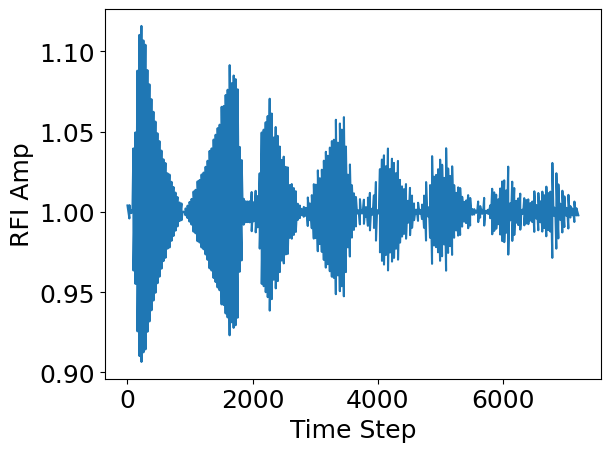

In [96]:
plt.plot(rfi_amp.flatten())
plt.xlabel('Time Step')
plt.ylabel('RFI Amp')
# plt.xlim(60, 120)
# plt.xlim(0, 32)

Text(0, 0.5, '')

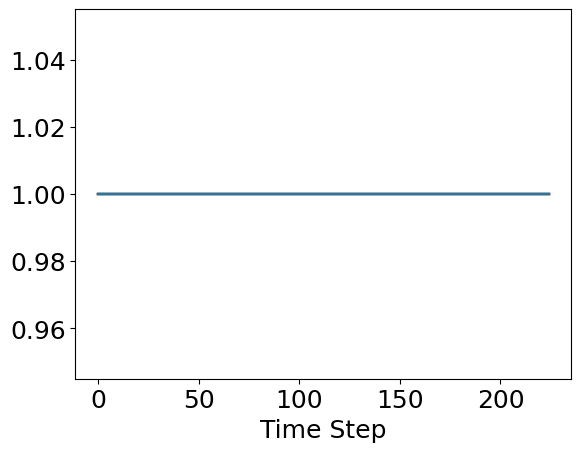

In [100]:
# plt.plot(np.abs(rfi_vis_fine.reshape(n_time, n_int, n_bl).mean(axis=1))[:,::100])
plt.plot(np.abs(rfi_vis_fine.reshape(n_time, n_int, n_bl)[:,0,:])[:,::100])
plt.xlabel('Time Step')
plt.ylabel('')

Text(0, 0.5, '')

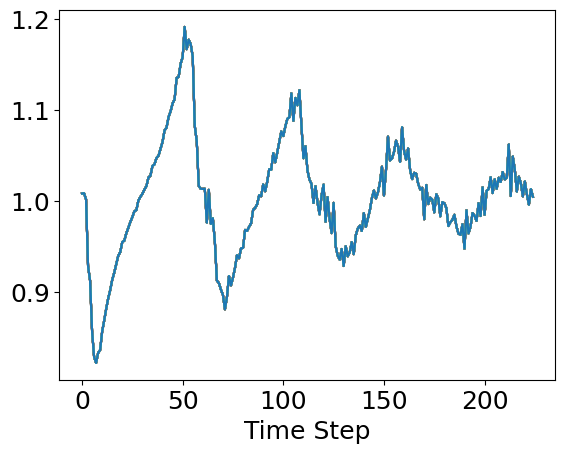

In [94]:
# plt.plot(np.abs(rfi_vis_fine.reshape(n_time, n_int, n_bl).mean(axis=1))[:,::100])
plt.plot(np.abs(rfi_vis_fine.reshape(n_time, n_int, n_bl)[:,0,:])[:,::100])
plt.xlabel('Time Step')
plt.ylabel('')

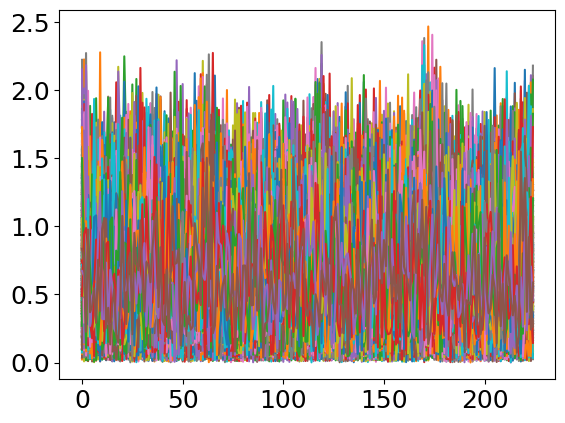

In [101]:
plt.plot(np.abs(vis_rfi_est-(vis_cal-vis_ast)));

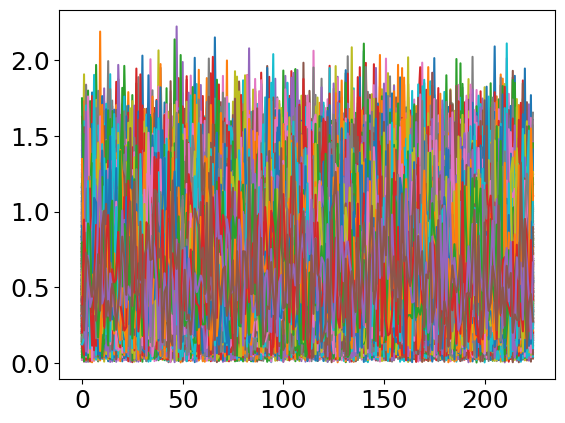

In [105]:
plt.plot(np.abs(noise));

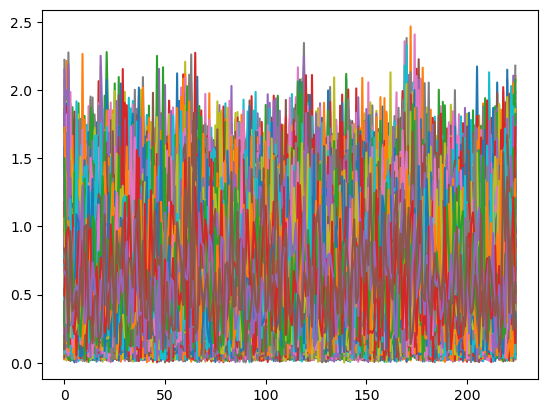

In [75]:
plt.plot(np.abs(vis_rfi_est-(vis_cal-vis_ast)));

[]

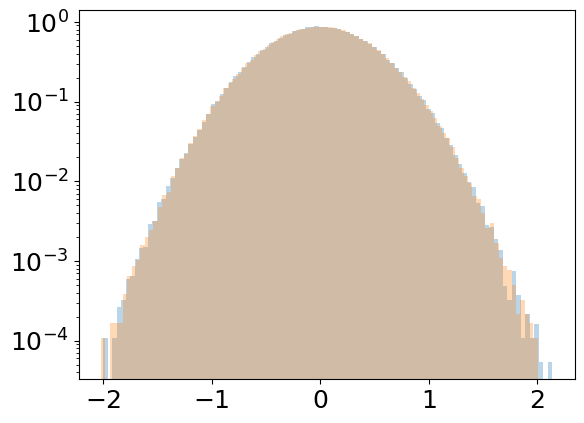

In [106]:
plt.hist(noise.real.flatten(), bins=100, alpha=0.3, density=True)
plt.hist(noise.imag.flatten(), bins=100, alpha=0.3, density=True);
plt.semilogy()

[]

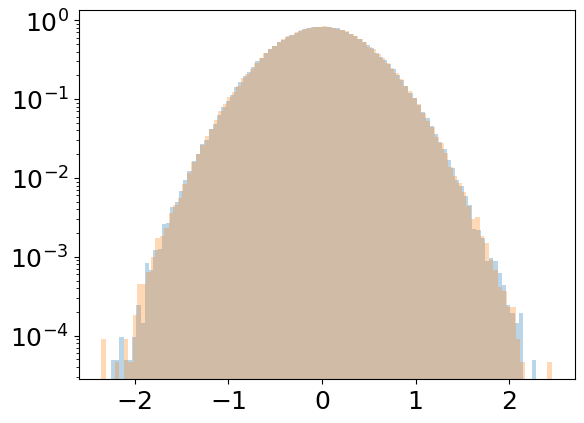

In [102]:
plt.hist((vis_corr-vis_ast).real.flatten(), bins=100, alpha=0.3, density=True)
plt.hist((vis_corr-vis_ast).imag.flatten(), bins=100, alpha=0.3, density=True);
plt.semilogy()

[]

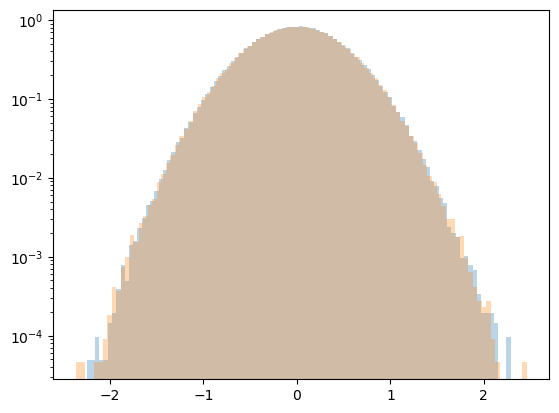

In [76]:
plt.hist((vis_corr-vis_ast).real.flatten(), bins=100, alpha=0.3, density=True)
plt.hist((vis_corr-vis_ast).imag.flatten(), bins=100, alpha=0.3, density=True);
plt.semilogy()

In [103]:
(vis_corr-vis_ast).real.std(), (vis_corr-vis_ast).imag.std(), (vis_corr-vis_ast).std()

(Array(0.48478371, dtype=float64),
 Array(0.48463534, dtype=float64),
 Array(0.6854828, dtype=float64))

In [70]:
(vis_corr-vis_ast).real.std(), (vis_corr-vis_ast).imag.std(), (vis_corr-vis_ast).std()

(Array(0.48584138, dtype=float64),
 Array(0.48562184, dtype=float64),
 Array(0.68692825, dtype=float64))